## Project description

You are data analyst of big on-line store. Marketing dep. and you prepared list of hypotheses for revenue increase.
Launch A/B-test and analyze results. 

## Description of the data

**orders.csv file.**
- TransactionID — order ID;
- visitorID — ID of the user who made the order;
- date — the date when the order was made;
- revenue — order revenue;
- group — the A/B test group that the order was placed in.

**visitors.csv file.**
- date — date;
- group — A/B test group;
- visitors — the number of users on the specified date in the specified A/B test group

# Project navigation

[Analyzing A/B-test](#Analyzing-A/B-test)

 - [1. Plotting cumulative revenue by group](#1.-Plotting-cumulative-revenue-by-group)

 - [2. Plotting cumulative average ticket by group](#2.-Plotting-cumulative-average-ticket-by-group)

 - [3. Plotting proportional change in the cumulative average ticket of group B to group A](#3.-Plotting-proportional-change-in-the-cumulative-average-ticket-of-group-B-to-group-A)

 - [4. Plotting cumulative average order qty per visitor by group](#4.-Plotting-cumulative-average-order-qty-per-visitor-by-group)

 - [5. Plotting proportional change in the cumulative average order qty per visitor of group B to group A](#5.-Plotting-proportional-change-in-the-cumulative-average-order-qty-per-visitor-of-group-B-to-group-A)

 - [6. Building scatter plot of order qty per visitor](#6.-Building-scatter-plot-of-order-qty-per-visitor)

 - [7. Calculating 95th and 99th percentiles of order qty per visitor](#7.-Calculating-95th-and-99th-percentiles-of-order-qty-per-visitor)

 - [8. Building scatter plot of order revenue](#8.-Building-scatter-plot-of-order-revenue)

 - [9. Calculating 95th and 99th percentiles of order revenue](#9.-Calculating-95th-and-99th-percentiles-of-order-revenue)

 - [10. Calculating statistical significance of differences in average order qty per visitor between groups based on raw data](#10.-Calculating-statistical-significance-of-differences-in-average-order-qty-per-visitor-between-groups-based-on-raw-data)

 - [11. Calculating statistical significance of differences in average ticket between groups based on raw data](#11.-Calculating-statistical-significance-of-differences-in-average-ticket-between-groups-based-on-raw-data)

 - [12. Calculating statistical significance of differences in average order qty per visitor between groups based on cleared data](#12.-Calculating-statistical-significance-of-differences-in-average-order-qty-per-visitor-between-groups-based-on-cleared-data)

 - [13. Calculating statistical significance of differences in average ticket between groups based on raw data](#13.-Calculating-statistical-significance-of-differences-in-average-ticket-between-groups-based-on-raw-data)

[Main summary](#Main-summary)

In [1]:
# importing libraries
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()

In [2]:
# reading files
orders = pd.read_csv('orders.csv')
visitors = pd.read_csv('visitors.csv')

In [3]:
# writing function to output general info regarding dataframes

def display_general_info(df):

    # general info
    df.info()

    # first 5 rows
    display(df.head())
    
    # check explicit duplicates
    display(df.duplicated().sum())

In [4]:
display_general_info(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


0

In [5]:
display_general_info(visitors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


0

No missing values were found in datasets. It is necessary to convert dates to the date type and change names of several columns of dataframes.

In [6]:
# rename several columns in orders
orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}, inplace=True)

In [7]:
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

In [8]:
# Checking through logical filtering do we have same user_id in both groups. Then through duplicated().sum()  - are there at least 1 or more users in both groups
orders[orders['visitor_id'].isin(orders[orders['group'] == 'A']['visitor_id']) & orders['visitor_id'].isin(orders[orders['group'] == 'B']['visitor_id'])].duplicated().sum()

0

In [9]:
# change data type format
orders['date']=pd.to_datetime(orders['date'])
visitors['date']=pd.to_datetime(visitors['date'])

## Analyzing A/B-test

### 1. Plotting cumulative revenue by group

In [10]:
dates_groups = orders[['date', 'group']].drop_duplicates()

In [11]:
# prepare aggregated dataframe by orders and visitors
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

In [12]:
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

In [13]:
# merging 2 dataframes to form cumulative data
cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulative_data.columns = [
    'date',
    'group',
    'orders_num',
    'users',
    'revenue',
    'visitors_sum',
]

cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders_num']]
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders_num']]

Let's check if  **cumulative_data** dataframes were created correctly. Compare minimum and maximum dates to dates from the original dataframe **orders**.

In [14]:
display(cumulative_data['date'].min())
display(cumulative_data['date'].max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

In [15]:
display(orders['date'].min())
display(orders['date'].max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

Min and max dates are same between new and initial dataframe.

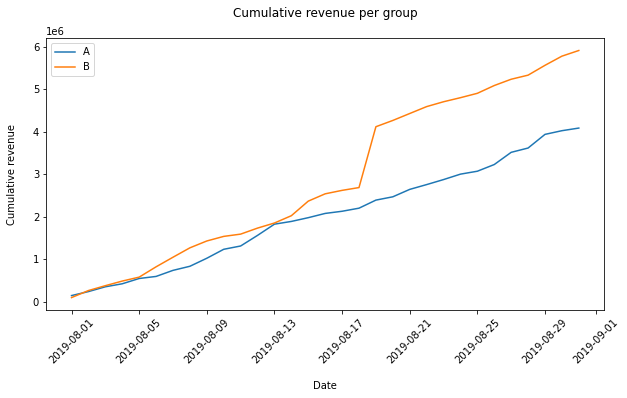

In [16]:
# plotting cumulative revenue per group
plt.figure(figsize=(10,5))
plt.grid(False)
plt.title('Cumulative revenue per group\n  ')
plt.xlabel('\nDate')
plt.ylabel('Cumulative revenue\n')


plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')

plt.xticks(rotation=45)
plt.legend()
plt.show()

Graph shows that cumulative revenue of group `B` became higher day by day in relation to group A. Cumulative revenue of group B by the end of the test is almost 6 million. which is 1.5 times higher than indicator of group A - about 4 million. 
But cumulative revenue of group B began to grow sharply starting from August 17, 2019. At the same time, curve of group A looks more stable. It is possible that anomalies appeared in group B , for ex., visitors who made purchases for large amounts and thus dramatically affected the results of the A/B test. Next, let's check these assumptions.

### 2. Plotting cumulative average ticket by group

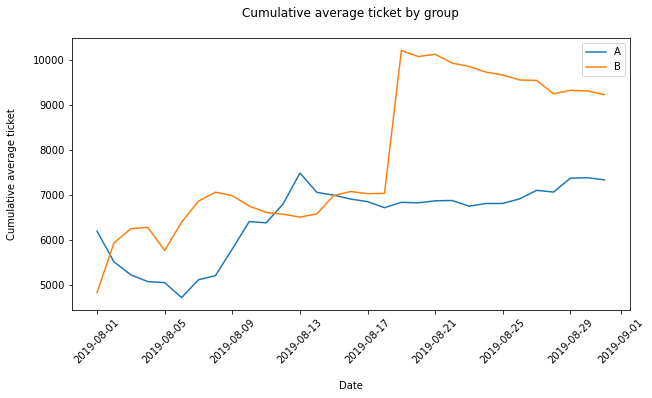

In [17]:
plt.figure(figsize=(10,5))
plt.grid(False)
plt.title('Cumulative average ticket by group\n  ')
plt.xlabel('\nDate')
plt.ylabel('Cumulative average ticket\n')

plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders_num'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders_num'], label='B')

plt.xticks(rotation=45)
plt.legend() 
plt.show()

Same situation applies to the cumulative average ticket. Cumulative average ticket of group B by the end of the test is 9,000, which is 30% higher than the indicator of group A - about 7000. If indicator of group A has stabilized since August 17, then indicator of group B increased sharply on that day, and then gradually began to fall. Assumption of anomalies in group B, starting from August 17, remains valid.

### 3. Plotting proportional change in the cumulative average ticket of group B to group A

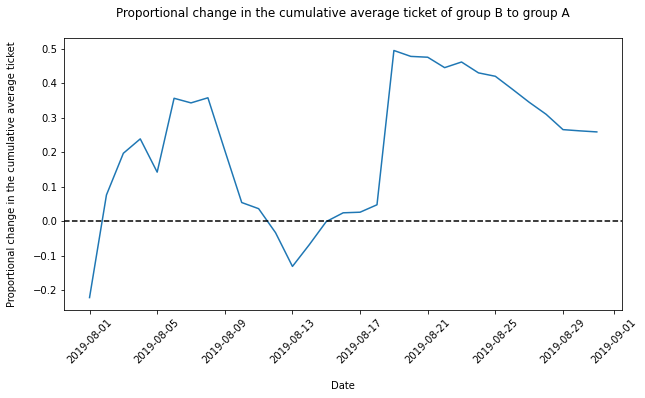

In [18]:
# merging data
merged_сumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10,5))
plt.grid(False)
plt.title('Proportional change in the cumulative average ticket of group B to group A\n  ')
plt.xlabel('\nDate')
plt.ylabel('Proportional change in the cumulative average ticket\n')

# plotting propotions between average tickets
plt.plot(merged_сumulative_revenue['date'], (merged_сumulative_revenue['revenueB']/merged_сumulative_revenue['orders_numB'])/(merged_сumulative_revenue['revenueA']/merged_сumulative_revenue['orders_numA'])-1)

# add axis X
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.show()

Graph of proportional change in the cumulative average ticket of group B to group A also shows sharp jump on August 17, and then its gradual decrease to the level of 0.3 (cumulative average ticket of group B is 30% higher than cumulative average check of group A by the end of the test).

### 4. Plotting cumulative average order qty per visitor by group

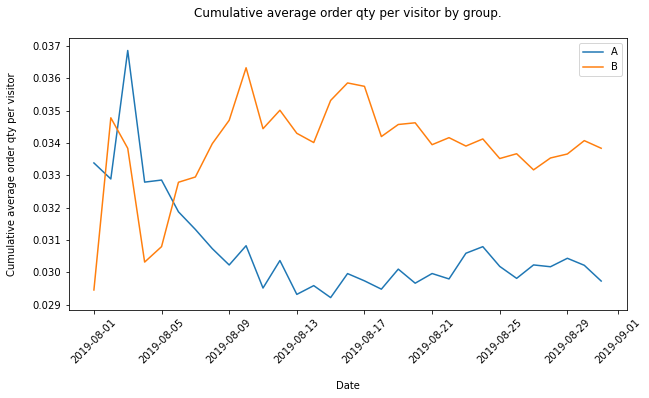

In [19]:
cumulative_data['conversion'] = cumulative_data['orders_num']/cumulative_data['visitors_sum']

# filtering data for group A
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']

# filtering data for group B
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

plt.figure(figsize=(10,5))
plt.grid(False)
plt.title('Cumulative average order qty per visitor by group.\n  ')
plt.xlabel('\nDate')
plt.ylabel('Cumulative average order qty per visitor\n')

plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')

plt.xticks(rotation=45)
plt.legend()
plt.show()

Plot of cumulative average order qty per visitor shows that group B won it against group A during whole test period.

### 5. Plotting proportional change in the cumulative average order qty per visitor of group B to group A

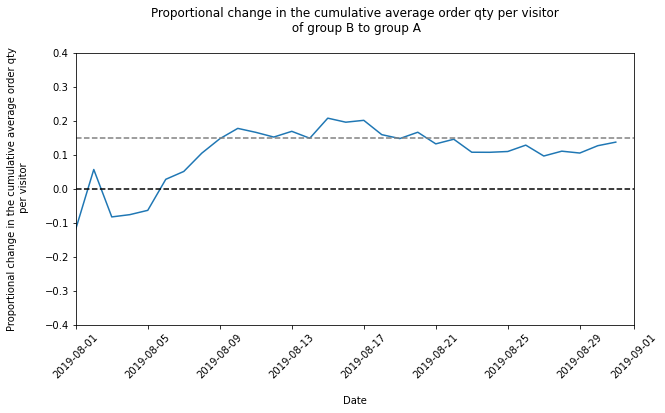

In [20]:
merged_cumulative_conversions = cumulative_data_A[['date','conversion']].merge(cumulative_data_B[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10,5))
plt.grid(False)
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--') # show 15% differance in metric group B to group A
plt.axis(["2019-08-01", '2019-09-01', -0.4, 0.4])
plt.title('Proportional change in the cumulative average order qty per visitor\n of group B to group A\n  ')
plt.xlabel('\nDate')
plt.ylabel('Proportional change in the cumulative average order qty\n per visitor\n')

plt.xticks(rotation=45)
plt.show()

As a result, cumulative average order qty per visitor of group B steadily increased to group A. Difference by the end of the test was almost 15%.

### 6. Building scatter plot of order qty per visitor

In [21]:
# group by visitors and calculate unique order qty per visitor
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['user_id', 'orders_cnt']
orders_by_users.sort_values(by='orders_cnt', ascending=False).head(10)

,user_id,orders_cnt
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


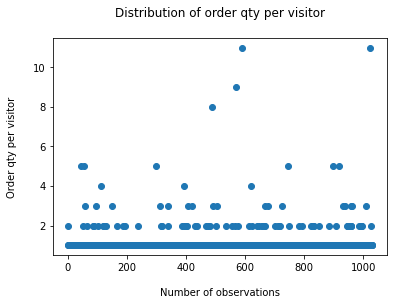

In [22]:
# number set from 0 to number of observations in orders_by_users
x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders_cnt'])

plt.title('Distribution of order qty per visitor\n  ')
plt.xlabel('\nNumber of observations')
plt.ylabel('Order qty per visitor\n')
plt.show()

Only several visitors who have made more than 2 orders. These may be anomalies. Next, let's use percentile to see general order qty per visitor - 2 or less?

### 7. Calculating 95th and 99th percentiles of order qty per visitor

In [23]:
# method np.percentile('column', [percentile1, percentile2, percentile3]) identify percentiles.
print(np.percentile(orders_by_users['orders_cnt'], [90, 95, 99]))

[1. 2. 4.]


No more than 5% of visitors have made more than 2 orders, and 1% - more than 4. We recommend selecting limit of 2 orders per visitor and consider all other values abnormal.

### 8. Building scatter plot of order revenue

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
682,1216533772,4266935830,2019-08-29,78990,B
662,1811671147,4266935830,2019-08-29,78990,A
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A


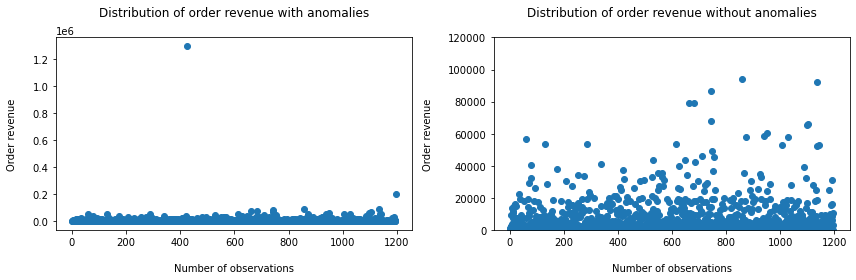

In [24]:
display(orders.sort_values(by='revenue', ascending=False).head(10))

plt.figure(figsize = (12,4))
# 1st plot with anomalies
ax1 = plt.subplot(1,2,1)
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Distribution of order revenue with anomalies\n  ')
plt.xlabel('\nNumber of observations')
plt.ylabel('Order revenue\n')

# 2st plot without anomalies
ax2 = plt.subplot(1,2,2)
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Distribution of order revenue without anomalies\n  ')
plt.xlabel('\nNumber of observations')
plt.ylabel('Order revenue\n')
plt.ylim(0, 120000)

plt.tight_layout()
plt.show()

Most part of orders has revenue up to 100K. There are several anomalies at level of 200 thousand and 1.3 million.

### 9. Calculating 95th and 99th percentiles of order revenue

In [25]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[18168.  28000.  58233.2]


No more than 5% of orders have revenue more than 28k, and 1% - more than 58k. We recommend choosing limit of 28 thousand per order and considering all other revenues as abnormal.

### 10. Сalculating statistical significance of differences in average order qty per visitor between groups based on raw data

Preparing data from dataframes `visitors` and `orders`. Combining data into a table called `data`. Then display first 5 rows of  `data`.

In [26]:
# prepare data about order qty per visitor by groups

visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_dateA']

visitors_A_cummulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_dateA': 'sum'}
    ),
    axis=1,
)
visitors_A_cummulative.columns = ['date', 'visitors_cummulative_A']

visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_dateB']

visitors_B_cummulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_dateB': 'sum'}
    ),
    axis=1,
)
visitors_B_cummulative.columns = ['date', 'visitors_cummulative_B']

orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_A_daily.columns = ['date', 'orders_per_dateA', 'revenue_per_dateA']

orders_A_cummulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_dateA': 'sum', 'revenue_per_dateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_A_cummulative.columns = [
    'date',
    'orders_cummulative_A',
    'revenue_cummulative_A',
]

orders_B_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_B_daily.columns = ['date', 'orders_per_dateB', 'revenue_per_dateB']

orders_B_cummulative = orders_B_daily.apply(
    lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_dateB': 'sum', 'revenue_per_dateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_B_cummulative.columns = [
    'date',
    'orders_cummulative_B',
    'revenue_cummulative_B',
]

data = (
    orders_A_daily.merge(
        orders_B_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_B_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,orders_per_dateA,revenue_per_dateA,orders_per_dateB,revenue_per_dateB,orders_cummulative_A,revenue_cummulative_A,orders_cummulative_B,revenue_cummulative_B,visitors_per_dateA,visitors_per_dateB,visitors_cummulative_A,visitors_cummulative_B
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [27]:
# calculating statistical significance of difference in average order qty per visitor between the groups
# creatingx variables ordersByUsersA and ordersByUsersB with columns ['visitor_id', 'orders']. For users who made at least 1 order, we'll indicate order qty 

orders_by_usersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_usersA.columns = ['visitor_id', 'orders_A']

orders_by_usersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_usersB.columns = ['visitor_id', 'orders_B']

**Hypothesis test:** there are differences in the average orders qty per visitor between groups based on raw data.

H_0: No differences in the average orders qty per visitor between groups based on raw data.

H_1: There are differences in the average orders qty per visitor between groups based on raw data.

alpha = 0.05

We will test hypothesis using the Mann-Whitney U test here and throughout, as criteria ,which we are considering, do not have normal distribution. Samples contain outliers, anomalies, heavy tails, which may affect test results.

In [28]:
# Declaring variables sampleA and sampleB, where number of orders will correspond to users from different groups. who doesnt place any order, null will be assigned. This is necessary to prepare the samples for Mann-Whitney U test.

sampleA = pd.concat([orders_by_usersA['orders_A'],pd.Series(0, index=np.arange(data['visitors_per_dateA'].sum() - len(orders_by_usersA['orders_A'])), name='orders_A')],axis=0)

sampleB = pd.concat([orders_by_usersB['orders_B'],pd.Series(0, index=np.arange(data['visitors_per_dateB'].sum() - len(orders_by_usersB['orders_B'])), name='orders_B')],axis=0)

# checking проверяем criterias by Mann-Whitney U test
alpha=0.05
results=stats.mannwhitneyu(sampleA, sampleB)
print('p-value: ', "{0:.3f}".format(results.pvalue))
print('Proportional changing of average order qty group B to group A: ', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

if results.pvalue < alpha:
    print('Reject null hypothesis')
else:
    print(
        'Null hypothesis could not be rejected'
    )

p-value:  0.017
Proportional changing of average order qty group B to group A:  0.138
Reject null hypothesis


P-value is significantly less than 0.05, therefore we reject the null hypothesis. Analysis of the "raw data" reports that there are statistically significant differences in average order qty between the groups. Proportional increase in average of group B to group A is 13.8%.
It is necessary to compare average tickets for "raw data", and then both metrics again after removing outliers.

### 11.  Сalculating statistical significance of differences in average ticket between groups based on raw data 

**Hypothesis test:** there are differences in the average ticket between groups based on raw data.

H_0: No differences in the average ticket between groups based on raw data.

H_1: There are differences in the average ticket between groups based on raw data.

alpha = 0.05

In [29]:
alpha=0.05
results=stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])
print('p-value: ', '{0:.3f}'.format(results.pvalue))
print('Proportional changing of average ticket group B to group A: ','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

if results.pvalue < alpha:
    print('Reject null hypothesis')
else:
    print(
        'Null hypothesis could not be rejected'
    )

p-value:  0.729
Proportional changing of average ticket group B to group A:  0.259
Null hypothesis could not be rejected


P-value is greater than 0.05 — there are no statistically significant differences in average ticket between groups. However, Proportional changing of average ticket between groups is 25%, we cant ignore it.

### 12. Сalculating statistical significance of differences in average order qty per visitor between groups based on cleared data

In [30]:
# limit values for order qty and the revenue to 'int' data type
percentile_revenue = np.percentile(orders['revenue'], [95])
percentiles_int_revenue = int(percentile_revenue)

percentile_orders = np.percentile(orders_by_users['orders_cnt'], [95])
percentiles_int_orders = int(percentile_revenue)


# clearing data, removing order qty per visitor more than 2 and revenue more than 28 000
users_with_many_orders = pd.concat(
    [
        orders_by_usersA[orders_by_usersA['orders_A'] > percentiles_int_orders]['visitor_id'],
        orders_by_usersB[orders_by_usersB['orders_B'] > percentiles_int_orders]['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > percentiles_int_revenue]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)


sample_A_filtered = pd.concat(
    [
        orders_by_usersA[
            np.logical_not(orders_by_usersA['visitor_id'].isin(abnormal_users))
        ]['orders_A'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_dateA'].sum() - len(orders_by_usersA['orders_A'])
            ),
            name='orders_A',
        ),
    ],
    axis=0,
)

sample_B_filtered = pd.concat(
    [
        orders_by_usersB[
            np.logical_not(orders_by_usersB['visitor_id'].isin(abnormal_users))
        ]['orders_B'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_dateB'].sum() - len(orders_by_usersB['orders_B'])
            ),
            name='orders_B',
        ),
    ],
    axis=0,
)

**Hypothesis test:** there are differences in the average orders qty per visitor between groups based on cleared data.

H_0: No differences in the average orders qty per visitor between groups based on cleared data.

H_1: There are differences in the average orders qty per visitor between groups based on cleared data.

alpha = 0.05

In [31]:
# checking проверяем criterias by Mann-Whitney U test
alpha=0.05
results=stats.mannwhitneyu(sample_A_filtered, sample_B_filtered)

print('p-value: ', '{0:.3f}'.format(results.pvalue))
print('Proportional changing of average order qty group B to group A: ','{0:.3f}'.format(sample_B_filtered.mean()/sample_A_filtered.mean()-1))

if results.pvalue < alpha:
    print('Reject null hypothesis')
else:
    print(
        'Null hypothesis could not be rejected'
    )

p-value:  0.019
Proportional changing of average order qty group B to group A:  0.140
Reject null hypothesis


As case of raw data, statistical significance has been achieved. Segment B is significantly better than segment A (by 14%).

### 13. Сalculating statistical significance of differences in average ticket between groups based on raw data

**Hypothesis test:** there are differences in the average ticket between groups based on cleared data.

H_0: No differences in the average ticket between groups based on cleared data.

H_1: There are differences in the average ticket between groups based on raw data.

alpha = 0.05

In [32]:
# checking проверяем criterias by Mann-Whitney U test

alpha=0.05
results=stats.mannwhitneyu(orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )

print('p-value: ', '{0:.3f}'.format(results.pvalue))
print('Proportional changing of average ticket group B to group A:  ','{0:.3f}'.format(orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1))

if results.pvalue < alpha:
    print('Reject null hypothesis')
else:
    print(
        'Null hypothesis could not be rejected'
    )

p-value:  0.863
Proportional changing of average ticket group B to group A:   -0.013
Null hypothesis could not be rejected


Even after clearing  data from anomalies, P-value is still more than 0.05 — statistically significant differences in average ticket between the groups were not found. TProportional changing of average ticket group B to group A were disappeared (-2% of group B from group A).

<div style="border:solid blue 3px; padding: 20px">

# Main summary

We conducted analysis of A/B test using the Mann-Whitney test and calculations of proportional changes in cumulative metrics, based on obtained data, following conclusions were made:
- There is statistically significant difference in order qty per visitor about 15% between the groups according to raw data and after filtering anomalies.
- According to raw data, there is no statistically significant difference in  average ticket between the groups, as well as, after removal of anomalies.
- The graph of difference in order qty per visitor between groups indicates that results of group B are better than group A: they tend to grow, or they are fixed near the average value.
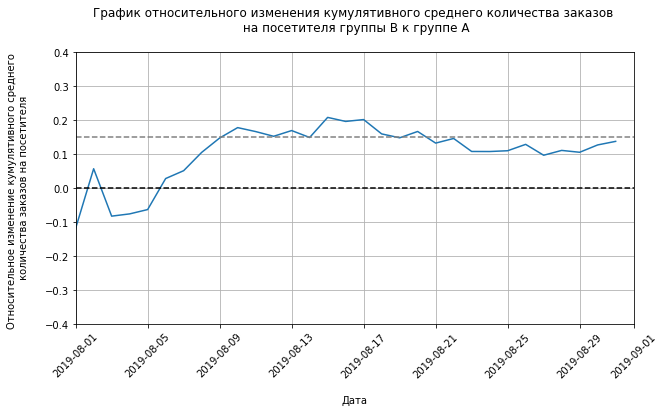
- The graph of difference in average ticket is fluctuating: it helped us to indicate anomalies. It is impossible to draw certain conclusions from graph. After clearing data of anomalies, there were no differences in the Mann-Whitney test, while proportional changes between the groups according to this metric practically disappeared.
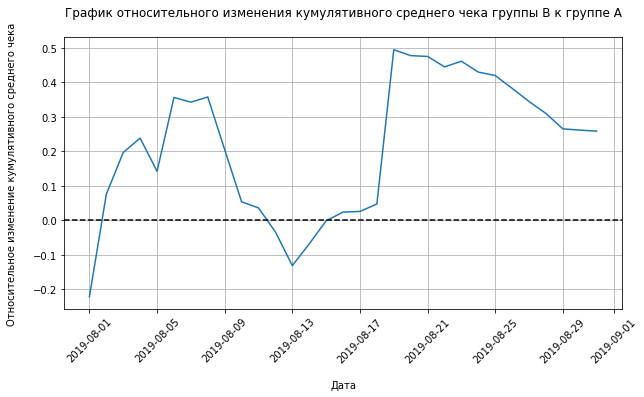

**We recommend stopping test and fixing win of group A over group B. Despite the victory in terms of order qty per visitor at the level of 14% by group B, unfortunately, the average ticket turned out to be lower than average ticket of group A by the end of the test**